# import


In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.csgraph import floyd_warshall
import math
import urllib.request
import io
import zipfile
import json

# function


## get data 

https://networkx.org/documentation/stable/auto_examples/graph/plot_football.html#sphx-glr-auto-examples-graph-plot-football-py

In [53]:
def get_football_graph_data():
    url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

    sock = urllib.request.urlopen(url)  # open URL
    s = io.BytesIO(sock.read())  # read into BytesIO "file"
    sock.close()

    zf = zipfile.ZipFile(s)  # zipfile object
    txt = zf.read("football.txt").decode()  # read info file
    gml = zf.read("football.gml").decode()  # read gml data
    # throw away bogus first line with # from mejn files
    gml = gml.split("\n")[1:]
    G = nx.parse_gml(gml)  # parse gml data
    print(len(G))
    return G

https://ialab.it.monash.edu/webcola/examples/unconstrained.html

In [54]:
def get_webcola_graph_data():
    data = None
    with open("./data.json") as f:
        data = json.load(f)
    node_data = [i for i, _ in enumerate(data["nodes"])]
    edge_data = [[d["target"], d["source"]] for d in data["links"]]
    G = nx.Graph()
    G.add_nodes_from(node_data)
    G.add_edges_from(edge_data)
    return G

## util

In [39]:
def adjacency_matrix(G):
    A = np.zeros((len(G), len(G)))
    for i, ni in enumerate(G.nodes()):
        for j, nj in enumerate(G.nodes()):
            if G.has_edge(ni, nj):
                A[i][j] = 1
    return A

In [59]:
def plot_graph(
    G,
    P,
    options={"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1},
):
    nx.draw(G, P, **options)
    plt.show()

In [41]:
def get_graph_property(G):
    # layout_pos = nx.random_layout(G)
    # P = np.array(list(layout_pos.values()))
    P = nx.random_layout(G)
    D = floyd_warshall(adjacency_matrix(G), directed=False)
    W = np.array(
        [
            [1 / (dij * dij) if not dij == 0 and not dij == 0 else 0 for dij in di]
            for di in D
        ]
    )

    return P, D, W

In [44]:
def stress(P, D, W):
    stress_sum = 0
    for i, p in enumerate(P.values()):
        for j, q in enumerate(P.values()):
            stress_sum += W[i][j] * (
                (math.dist(p, q) - D[i][j]) * (math.dist(p, q) - D[i][j])
            )
    return stress_sum

# vis

## stress only


In [71]:
def plot_spring_layout(G):
    options={"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}
    P = nx.spring_layout(G)
    nx.draw(G, P, **options)
    plt.show()

In [42]:
def next_position(u, W, D, P):
    weight_sum = sum([w for w in W[u]])
    vu = P[u]
    x_sum = 0
    y_sum = 0
    for i, w in enumerate(W[u]):
        if i == u:
            continue

        vv = P[i]
        b = 1 / math.dist(vu, vv)
        x_sum += w * (vv[0] + D[u][i] * (vu[0] - vv[0]) * abs(b))
        y_sum += w * (vv[1] + D[u][i] * (vu[1] - vv[1]) * abs(b))

    return np.array([x_sum / weight_sum, y_sum / weight_sum])

In [43]:
def change_positions(W, D, P):
    for i in range(len(P)):
        next_p = next_position(i, W, D, P)
        P[i] = next_p
    return P

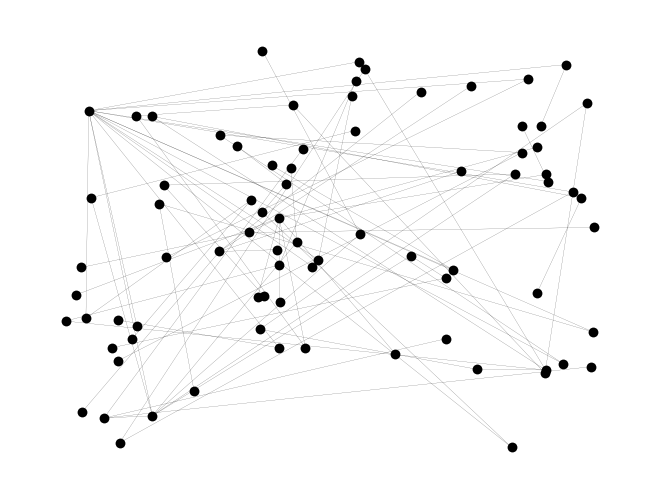

stress_value=5165.741701067275
stress_value=288.71300069577256

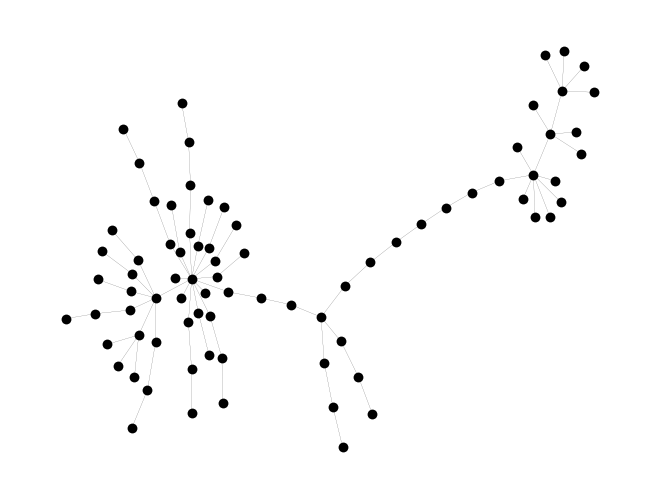

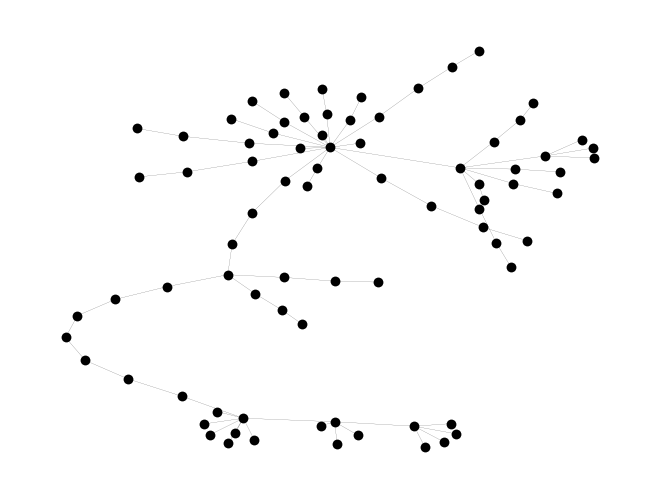

In [72]:
G = get_webcola_graph_data()
P, D, W = get_graph_property(G)

plot_graph(G, P)

stress_value = stress(P, D, W)
print(f"{stress_value=}")
while True:
    change_positions(W, D, P)

    next_stress = stress(P, D, W)
    if abs(stress_value - next_stress) < 0.001:
        break

    stress_value = next_stress
    print(f"\r{stress_value=}", end="")

plot_graph(G, P)
plot_spring_layout(G)

## general radial constraints


In [48]:
def diameter(D):
    return max([max(di) for di in D])

In [49]:
def radii(u, C, diam):
    min_c = min(C)
    max_c = max(C)
    offset = 0.00000001
    rate = 1 - (C[u] - min_c) / (max_c - min_c + offset)
    return diam * rate / 2

In [47]:
def calc_closeness_centrality(u, D):
    sum_d = sum([d for d in D[u]])
    return 1 / sum_d if not sum_d < 0.000_001 else 0

In [50]:
def next_position_general(u, t, W, D, P, R, Z):
    under = sum([(1 - t) * w + t * Z[u][-1]
                for i, w in enumerate(W[u]) if not i == u])

    norm = math.sqrt(P[u][0] ** 2 + P[u][1] ** 2)
    a = 1 / norm if not norm < 0.000_001 else 0
    upper_right_x = t * (R[u] * P[u][0] * a) * Z[u][-1]
    upper_right_y = t * (R[u] * P[u][1] * a) * Z[u][-1]

    if under < 0.000_001:
        return P[u]

    vu = P[u]
    x_sum = 0
    y_sum = 0
    for v in range(len(P)):
        if v == u:
            continue

        vv = P[v]
        d = math.dist(vu, vv)
        b = 1 / d if not d < 0.000_001 else 0
        x_sum += (1 - t) * W[u][v] * (
            vv[0] + D[u][v] * (vu[0] - vv[0]) * abs(b)
        ) + upper_right_x
        y_sum += (1 - t) * W[u][v] * (
            vv[1] + D[u][v] * (vu[1] - vv[1]) * abs(b)
        ) + upper_right_y

    return np.array([x_sum / under, y_sum / under])

In [51]:
def change_positions_general(t, W, D, P, R, Z):
    for i in range(len(P)):
        next_p = next_position_general(i, t, W, D, P, R, Z)
        P[i] = next_p
    return P

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]


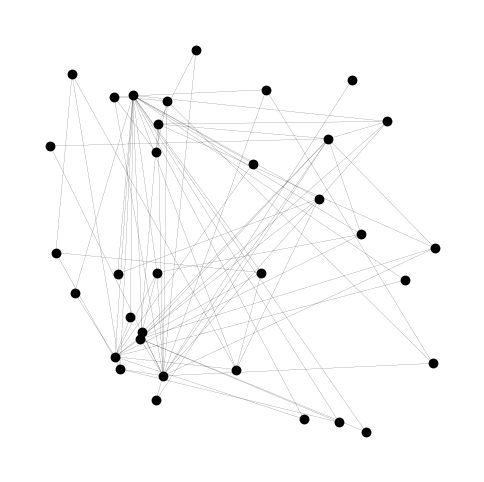

stress_value=639.2020609685512
stress_value=157.31958796597216


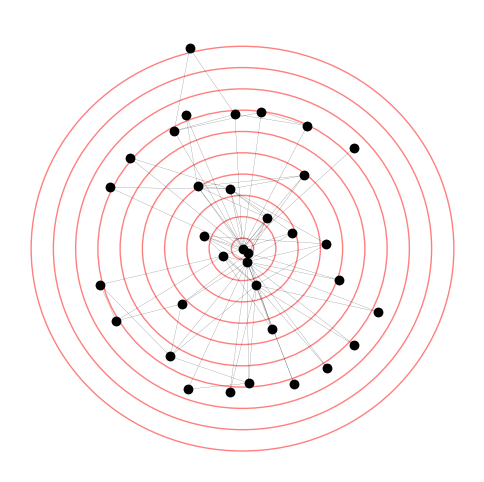

In [87]:
import networkx as nx
import numpy as np

G = nx.karate_club_graph()
# G = get_football_graph_data()
# G = get_webcola_graph_data()

P, D, W = get_graph_property(G)
nodes = list(G.nodes())
edges = list(G.edges())
print(edges)
P = {i: P[nodes[i]] for i in range(len(nodes))}


C = [calc_closeness_centrality(u, D) for u in range(len(P))]

diam = diameter(D)
R = [radii(i, C, diam) for i in range(len(P))]

D = [np.append(D[i], r) for i, r in enumerate(R)]
D.append(R + [0])

W = [np.append(row, 0) for row in W]
W.append([0] * len(W[0]))

Z = np.zeros_like(W)
for i in range(len(R)):
    r = 1 / (R[i] * R[i]) if R[i] > 0.000_001 else 0
    Z[i][-1] = r
    Z[-1][i] = r


# plot_graph(G, P)

options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

P = {nodes[i]: P[i] for i in range(len(nodes))}
plot_graph(G, P, options)
P = {i: P[nodes[i]] for i in range(len(nodes))}

k = 100
stress_value = stress(P, D, W)
print(f"{stress_value=}")

for i in range(k + 1):
    change_positions_general(i / k if not i == 0 else 0, W, D, P, R, Z)
    stress_value = stress(P, D, W)
    print(f"\r{stress_value=}", end="")
print()


fig = plt.figure(figsize=(6,6))
ax = plt.axes()
step = 0.25
rad = 0.125
for i in range(10):
    dc = plt.Circle((0, 0), radius=rad, fc="none", ec="red", fill=False, alpha=0.5)
    ax.add_patch(dc)
    rad += step

P = {nodes[i]: P[i] for i in range(len(nodes))}
plot_graph(G, P, options)
P = {i: P[nodes[i]] for i in range(len(nodes))}

## networkx 

- https://networkx.org/documentation/stable/auto_examples/graphviz_layout/plot_lanl_routes.html#sphx-glr-auto-examples-graphviz-layout-plot-lanl-routes-py

> This example needs Graphviz and PyGraphviz.

graphvis
- https://pygraphviz.github.io/documentation/stable/install.html

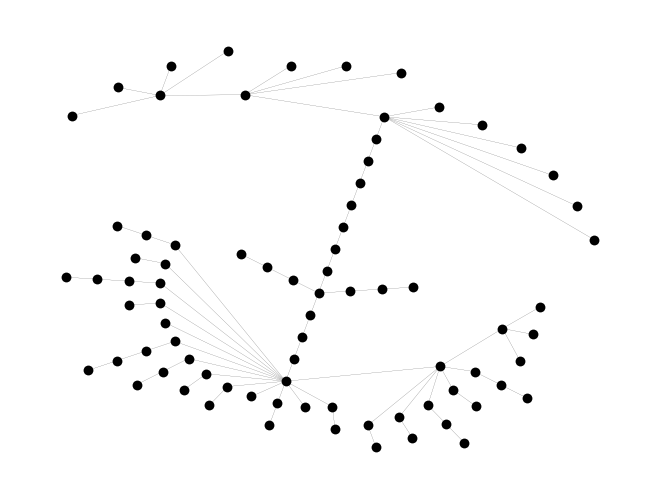

In [56]:
G = get_webcola_graph_data()
pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", root=0)
options = {"node_color": "black", "node_size": 50,
           "linewidths": 0, "width": 0.1}
nx.draw(G, pos, **options)
plt.show()